In [3]:
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import re
from ratelimit import limits, sleep_and_retry
from bs4 import BeautifulSoup

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_similarity_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Download NLP Corpora

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amiteshsinha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amiteshsinha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Get 10ks

In [5]:
cik_lookup = {
    'AMZN': '0001018724',
    'BMY': '0000014272',   
    'CNP': '0001130310',
    'CVX': '0000093410',
    'FL': '0000850209',
    'FRT': '0000034903',
    'HON': '0000773840'}

additional_cik = {
    'AEP': '0000004904',
    'AXP': '0000004962',
    'BA': '0000012927', 
    'BK': '0001390777',
    'CAT': '0000018230',
    'DE': '0000315189',
    'DIS': '0001001039',
    'DTE': '0000936340',
    'ED': '0001047862',
    'EMR': '0000032604',
    'ETN': '0001551182',
    'GE': '0000040545',
    'IBM': '0000051143',
    'IP': '0000051434',
    'JNJ': '0000200406',
    'KO': '0000021344',
    'LLY': '0000059478',
    'MCD': '0000063908',
    'MO': '0000764180',
    'MRK': '0000310158',
    'MRO': '0000101778',
    'PCG': '0001004980',
    'PEP': '0000077476',
    'PFE': '0000078003',
    'PG': '0000080424',
    'PNR': '0000077360',
    'SYY': '0000096021',
    'TXN': '0000097476',
    'UTX': '0000101829',
    'WFC': '0000072971',
    'WMT': '0000104169',
    'WY': '0000106535',
    'XOM': '0000034088'}

In [6]:
class SecAPI(object):
    SEC_CALL_LIMIT = {'calls': 10, 'seconds': 1}

    @staticmethod
    @sleep_and_retry
    # Dividing the call limit by half to avoid coming close to the limit
    @limits(calls=SEC_CALL_LIMIT['calls'] / 2, period=SEC_CALL_LIMIT['seconds'])
    def _call_sec(url):
        return requests.get(url)

    def get(self, url):
        return self._call_sec(url).text

In [7]:
sec_api = SecAPI()

In [8]:
def get_sec_data(cik, doc_type, start=0, count=60):
    newest_pricing_data = pd.to_datetime('2018-01-01')
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)
        if pd.to_datetime(entry.content.find('filing-date')\
                          .getText()) <= newest_pricing_data]

    return entries

## How the download works

In [9]:
example_ticker = 'AMZN'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')

pprint.pprint(sec_data[example_ticker][:5])

[('https://www.sec.gov/Archives/edgar/data/1018724/000101872417000011/0001018724-17-000011-index.htm',
  '10-K',
  '2017-02-10'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872416000172/0001018724-16-000172-index.htm',
  '10-K',
  '2016-01-29'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872415000006/0001018724-15-000006-index.htm',
  '10-K',
  '2015-01-30'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872414000006/0001018724-14-000006-index.htm',
  '10-K',
  '2014-01-31'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000119312513028520/0001193125-13-028520-index.htm',
  '10-K',
  '2013-01-30')]


### Download 10-ks

In [10]:
raw_fillings_by_ticker = {}
for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    desc = 'Downloading {} Fillings'.format(ticker)
    for index_url, file_type, file_date in tqdm(data, desc = desc, unit = 'filling' ):
        if (file_type == '10-K'):
            print('index url {}'.format(index_url))
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt') 
            raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)
            
print('Example Document:\n\n{}...'.\
      format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

index url https://www.sec.gov/Archives/edgar/data/1018724/000101872417000011/0001018724-17-000011-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/000101872416000172/0001018724-16-000172-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/000101872415000006/0001018724-15-000006-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/000101872414000006/0001018724-14-000006-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/000119312513028520/0001193125-13-028520-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/000119312512032846/0001193125-12-032846-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/000119312511016253/0001193125-11-016253-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/000119312510016098/0001193125-10-016098-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/000119312509014406/0001193125-09-014406-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/000119312508024707/0001193125-08-024707-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/000119312507034081/0001193125-07-034081-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/000119312506034166/0001193125-06-034166-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/000119312505047032/0001193125-05-047032-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/000119312504029488/0001193125-04-029488-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/000095014903000355/0000950149-03-000355-index.htm


index url https://www.sec.gov/Archives/edgar/data/1018724/0000891020-00-000622-index.html


index url https://www.sec.gov/Archives/edgar/data/1018724/0000891020-99-000375-index.html


index url https://www.sec.gov/Archives/edgar/data/14272/000001427217000047/0000014272-17-000047-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000001427216000288/0000014272-16-000288-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000001427215000055/0000014272-15-000055-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000001427214000054/0000014272-14-000054-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000119312513061678/0001193125-13-061678-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000119312512066416/0001193125-12-066416-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000119312511040120/0001193125-11-040120-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000119312510035167/0001193125-10-035167-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000119312509033538/0001193125-09-033538-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000119312508035566/0001193125-08-035566-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000119312507039915/0001193125-07-039915-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000119312506052456/0001193125-06-052456-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000119312505041808/0001193125-05-041808-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000119312504041353/0001193125-04-041353-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000104746903010810/0001047469-03-010810-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/000001427201500006/0000014272-01-500006-index.htm


index url https://www.sec.gov/Archives/edgar/data/14272/0000014272-00-000002-index.html


index url https://www.sec.gov/Archives/edgar/data/14272/0000014272-99-000002-index.html


index url https://www.sec.gov/Archives/edgar/data/14272/0000014272-98-000002-index.html


index url https://www.sec.gov/Archives/edgar/data/14272/0000014272-97-000008-index.html


index url https://www.sec.gov/Archives/edgar/data/14272/0000014272-96-000002-index.html


index url https://www.sec.gov/Archives/edgar/data/14272/0000014272-95-000004-index.html


index url https://www.sec.gov/Archives/edgar/data/14272/0000014272-94-000003-index.html


index url https://www.sec.gov/Archives/edgar/data/1130310/000113031017000006/0001130310-17-000006-index.htm


index url https://www.sec.gov/Archives/edgar/data/1130310/000113031016000031/0001130310-16-000031-index.htm


index url https://www.sec.gov/Archives/edgar/data/1130310/000113031015000008/0001130310-15-000008-index.htm


index url https://www.sec.gov/Archives/edgar/data/1130310/000113031014000005/0001130310-14-000005-index.htm


index url https://www.sec.gov/Archives/edgar/data/1130310/000113031013000006/0001130310-13-000006-index.htm


index url https://www.sec.gov/Archives/edgar/data/1130310/000113031012000011/0001130310-12-000011-index.htm


index url https://www.sec.gov/Archives/edgar/data/1130310/000113031011000006/0001130310-11-000006-index.htm


index url https://www.sec.gov/Archives/edgar/data/1130310/000113031010000006/0001130310-10-000006-index.htm


index url https://www.sec.gov/Archives/edgar/data/1130310/000113031009000004/0001130310-09-000004-index.htm


index url https://www.sec.gov/Archives/edgar/data/1130310/000095013408003670/0000950134-08-003670-index.htm


index url https://www.sec.gov/Archives/edgar/data/1130310/000095013407004335/0000950134-07-004335-index.htm


index url https://www.sec.gov/Archives/edgar/data/1130310/000095013406005252/0000950134-06-005252-index.htm


index url https://www.sec.gov/Archives/edgar/data/1130310/000095012905002466/0000950129-05-002466-index.htm


index url https://www.sec.gov/Archives/edgar/data/1130310/000095012904001267/0000950129-04-001267-index.htm


index url https://www.sec.gov/Archives/edgar/data/1130310/000095012903001299/0000950129-03-001299-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000009341017000013/0000093410-17-000013-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000009341016000049/0000093410-16-000049-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000009341015000010/0000093410-15-000010-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000009341014000011/0000093410-14-000011-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000009341013000003/0000093410-13-000003-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000095012312002976/0000950123-12-002976-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000095012311017688/0000950123-11-017688-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000095012310016846/0000950123-10-016846-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000089161809000054/0000891618-09-000054-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000095013408003672/0000950134-08-003672-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000095014907000074/0000950149-07-000074-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000095014906000076/0000950149-06-000076-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000095013405004137/0000950134-05-004137-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000095013404003128/0000950134-04-003128-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000095014903000567/0000950149-03-000567-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/000009341001000015/0000093410-01-000015-index.htm


index url https://www.sec.gov/Archives/edgar/data/93410/0000093410-00-000006-index.html


index url https://www.sec.gov/Archives/edgar/data/93410/0000093410-99-000034-index.html


index url https://www.sec.gov/Archives/edgar/data/93410/0000093410-96-000003-index.html


index url https://www.sec.gov/Archives/edgar/data/93410/0000093410-95-000012-index.html


index url https://www.sec.gov/Archives/edgar/data/93410/0000093410-94-000002-index.html


index url https://www.sec.gov/Archives/edgar/data/850209/000085020917000003/0000850209-17-000003-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000114420416090138/0001144204-16-090138-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000114420415019391/0001144204-15-019391-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000114420414019510/0001144204-14-019510-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000114420413019239/0001144204-13-019239-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000114420412017162/0001144204-12-017162-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000114420411017589/0001144204-11-017589-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000114420410016376/0001144204-10-016376-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000120677409000650/0001206774-09-000650-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000120677408000652/0001206774-08-000652-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000120677407000876/0001206774-07-000876-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000120677406000567/0001206774-06-000567-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000120677405000473/0001206774-05-000473-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000120677404000280/0001206774-04-000280-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000095012303006233/0000950123-03-006233-index.htm


index url https://www.sec.gov/Archives/edgar/data/850209/000095012302004331/0000950123-02-004331-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000003490317000008/0000034903-17-000008-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000003490316000045/0000034903-16-000045-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000003490315000014/0000034903-15-000014-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000003490314000009/0000034903-14-000009-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000003490313000006/0000034903-13-000006-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000003490312000008/0000034903-12-000008-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000119312511036800/0001193125-11-036800-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000119312510033308/0001193125-10-033308-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000119312509038641/0001193125-09-038641-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000119312508039905/0001193125-08-039905-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000119312507043678/0001193125-07-043678-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000119312506044561/0001193125-06-044561-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000119312505043736/0001193125-05-043736-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000095013304000888/0000950133-04-000888-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/000092838503000860/0000928385-03-000860-index.htm


index url https://www.sec.gov/Archives/edgar/data/34903/0000928385-99-000847-index.html


index url https://www.sec.gov/Archives/edgar/data/34903/0000928385-97-000296-index.html


index url https://www.sec.gov/Archives/edgar/data/34903/0000928385-96-000186-index.html


index url https://www.sec.gov/Archives/edgar/data/34903/0000898432-94-000032-index.html


index url https://www.sec.gov/Archives/edgar/data/773840/000093041317000391/0000930413-17-000391-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000093041316005457/0000930413-16-005457-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000093041315000621/0000930413-15-000621-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000093041314000634/0000930413-14-000634-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000093041313000907/0000930413-13-000907-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000093041312000976/0000930413-12-000976-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000093041311000961/0000930413-11-000961-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000093041310000784/0000930413-10-000784-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000093041309000801/0000930413-09-000801-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000093041308001037/0000930413-08-001037-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000093041307001369/0000930413-07-001369-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000095011706000980/0000950117-06-000980-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000095011705000756/0000950117-05-000756-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000095011704000868/0000950117-04-000868-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000095011703000910/0000950117-03-000910-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000095011702000539/0000950117-02-000539-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/000095011701000640/0000950117-01-000640-index.htm


index url https://www.sec.gov/Archives/edgar/data/773840/0000950117-98-000419-index.html


index url https://www.sec.gov/Archives/edgar/data/773840/0000950117-96-000146-index.html


index url https://www.sec.gov/Archives/edgar/data/773840/0000950117-95-000038-index.html


Example Document:

<SEC-DOCUMENT>0001018724-17-000011.txt : 20170210
<SEC-HEADER>0001018724-17-000011.hdr.sgml : 20170210
<ACCEPTANCE-DATETIME>20170209175636
ACCESSION NUMBER:		0001018724-17-000011
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		92
CONFORMED PERIOD OF REPORT:	20161231
FILED AS OF DATE:		20170210
DATE AS OF CHANGE:		20170209

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			AMAZON COM INC
		CENTRAL INDEX KEY:			0001018724
		STANDARD INDUSTRIAL CLASSIFICATION:	RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]
		IRS NUMBER:				911646860
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	000-22513
		FILM NUMBER:		17588807

	BUSINESS ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
		BUSINESS PHONE:		2062661000

	MAIL ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
</SEC-HEADER>
<DOCUMENT>
<TYPE>10-K
<S

In [11]:
def get_documents(text):
    """
    Extract the documents from the text

    Parameters
    ----------
    text : str
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
    """
    extracted_docs = []
    start_pattern = re.compile(r'<DOCUMENT>')
    end_pattern = re.compile(r'</DOCUMENT>')
    
    ## We chose indices in such a way that it containst all the contents
    ## between tags
    start_idx = [x.end() for x in re.finditer(start_pattern, text)]
    end_idx = [x.start() for x in re.finditer(end_pattern, text)]
    
    # append document body
    for doc_start, doc_end in zip(start_idx, end_idx):
        extracted_docs.append(text[doc_start:doc_end])
    return extracted_docs

def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """
    lookfor = re.compile(r'(?<=<TYPE>)\w+[^\n]+')
    
    
    return re.search(lookfor, doc).group(0).lower()

In [12]:
filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    desc = 'Getting Documents from {} Fillings'.format(ticker)
    for file_date, filling in tqdm(raw_fillings.items(), desc=desc, unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Getting Documents from HON Fillings: 100%|██████████| 20/20 [00:00<00:00, 55.79filling/s]

Document 0 Filed on 2017-02-10:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>amzn-20161231x10k.htm
<DESCRIPTION>FORM 10-K
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
	<he...

Document 1 Filed on 2017-02-10:

<TYPE>EX-12.1
<SEQUENCE>2
<FILENAME>amzn-20161231xex121.htm
<DESCRIPTION>COMPUTATION OF RATIO OF EARNINGS TO FIXED CHARGES
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http:...

Document 2 Filed on 2017-02-10:

<TYPE>EX-21.1
<SEQUENCE>3
<FILENAME>amzn-20161231xex211.htm
<DESCRIPTION>LIST OF SIGNIFICANT SUBSIDIARIES
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/h...


In [13]:
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})

## Preprocess the Data

In [14]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    return text


def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    return text

In [15]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    desc = 'Cleaning {} 10-Ks'.format(ticker)
    for ten_k in tqdm(ten_ks, desc=desc, unit='10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])

Cleaning HON 10-Ks: 100%|██████████| 20/20 [00:37<00:00,  1.89s/10-K]


### Lemmatize

In [16]:
def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """
    
    # TODO: Implement
    lemma = WordNetLemmatizer()
    
    return [lemma.lemmatize(word, 'v') for word in words]

In [17]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    desc = 'Lemmatize {} 10-Ks'.format(ticker)
    for ten_k in tqdm(ten_ks, desc=desc, unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))

Lemmatize HON 10-Ks: 100%|██████████| 20/20 [00:02<00:00,  6.8310-K/s]


### Remove Stopwords

In [18]:
lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]

print('Stop Words Removed')

Remove Stop Words for HON 10-Ks: 100%|██████████| 20/20 [00:01<00:00, 16.8210-K/s]

Stop Words Removed


## Analysis on 10Ks

We would be using the Loughran and McDonald sentiment word lists. These word lists cover the following sentiment:
- Negative 
- Positive
- Uncertainty
- Litigious
- Constraining
- Superfluous
- Modal

**Reference -**   
https://sraf.nd.edu/textual-analysis/resources/  
http://www.wjh.harvard.edu/~inquirer/spreadsheet_guide.htm  


This will allow us to do the sentiment analysis on the 10-ks. Let's first load these word lists. We'll be looking into a few of these sentiments.

https://drive.google.com/file/d/0B4niqV00F3msaFZGUEZNTGtBblU/view?usp=sharing

In [19]:
sentiments = ['negative', 'positive', 'uncertainty', \
              'litigious', 'constraining', 'interesting']
sentiment_df = pd.read_csv('LoughranMcDonald_MasterDictionary_2016.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')

In [20]:
sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication


## Bag of Words

In [21]:
def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    vectorizer = CountVectorizer(vocabulary=sentiment_words.values)
    
    return vectorizer.fit_transform(docs).toarray()

In [22]:
sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

### Jaccard Similarity

In [23]:
def get_jaccard_similarity(bag_of_words_matrix):
    """
    Get jaccard similarities for neighboring documents

    Parameters
    ----------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    jaccard_similarities : list of float
        Jaccard similarities for neighboring documents
    """
    
    # TODO: Implement
    jaccard_similarities = []
    bow = bag_of_words_matrix.astype(bool)
    
    for i in range(bag_of_words_matrix.shape[0] - 1):
        jaccard_similarities.append(\
           jaccard_similarity_score(bow[i], bow[i+1]))
    
    return jaccard_similarities

def plot_similarities(similarities_list, dates, title, labels):
    assert len(similarities_list) == len(labels)

    plt.figure(1, figsize=(10, 7))
    for similarities, label in zip(similarities_list, labels):
        plt.title(title)
        plt.plot(dates, similarities, label=label)
        plt.legend()
        plt.xticks(rotation=90)

    plt.show()

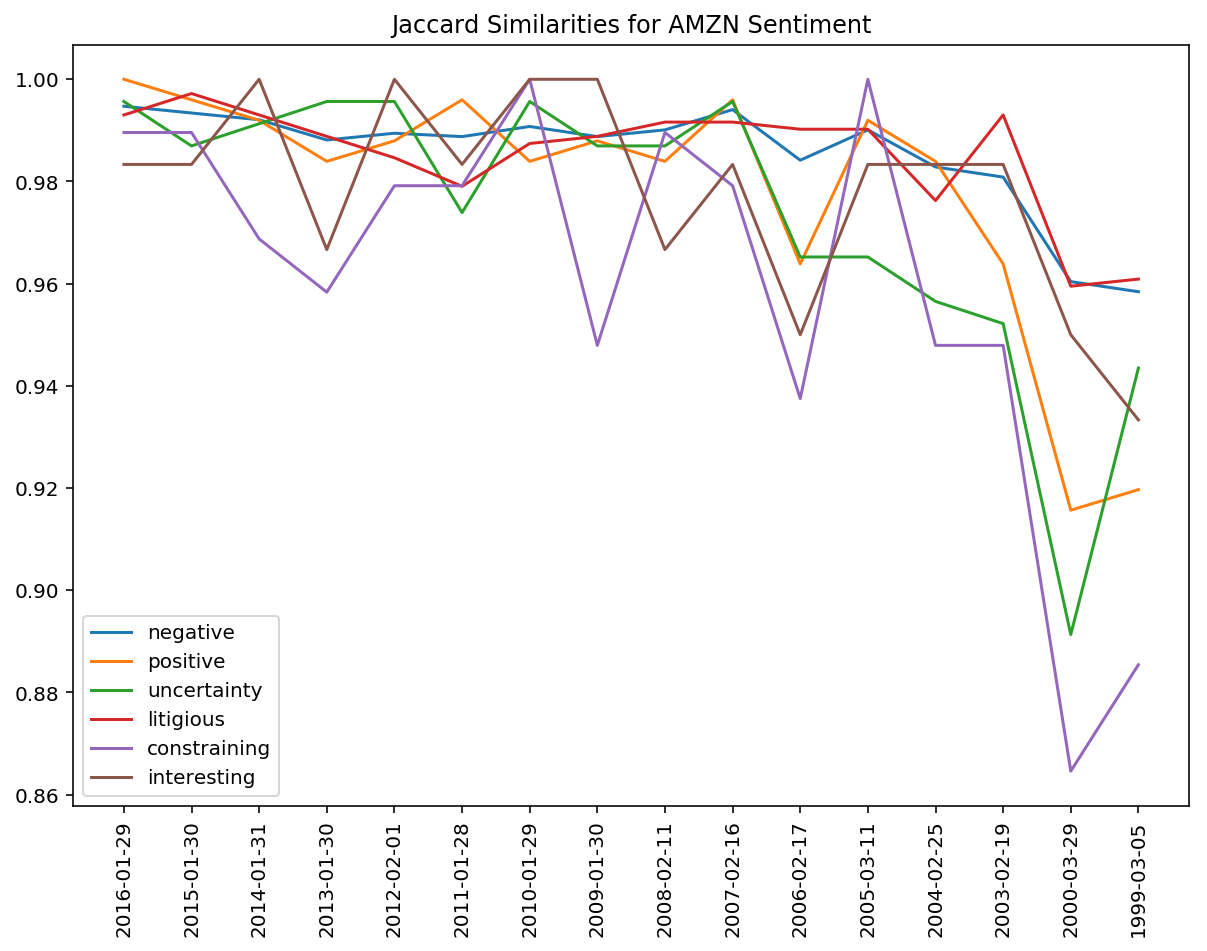

In [24]:
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}


plot_similarities(
    [jaccard_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

## TFIDF

In [25]:
def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    vectorizer = TfidfVectorizer(vocabulary=sentiment_words.values)
    
    return vectorizer.fit_transform(docs).toarray()

In [26]:
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

### Cosine Similarity

In [27]:
def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    
    # TODO: Implement
    cosine_similarities = list(np.diag(cosine_similarity(tfidf_matrix, tfidf_matrix), k=1))
    
    
    return cosine_similarities

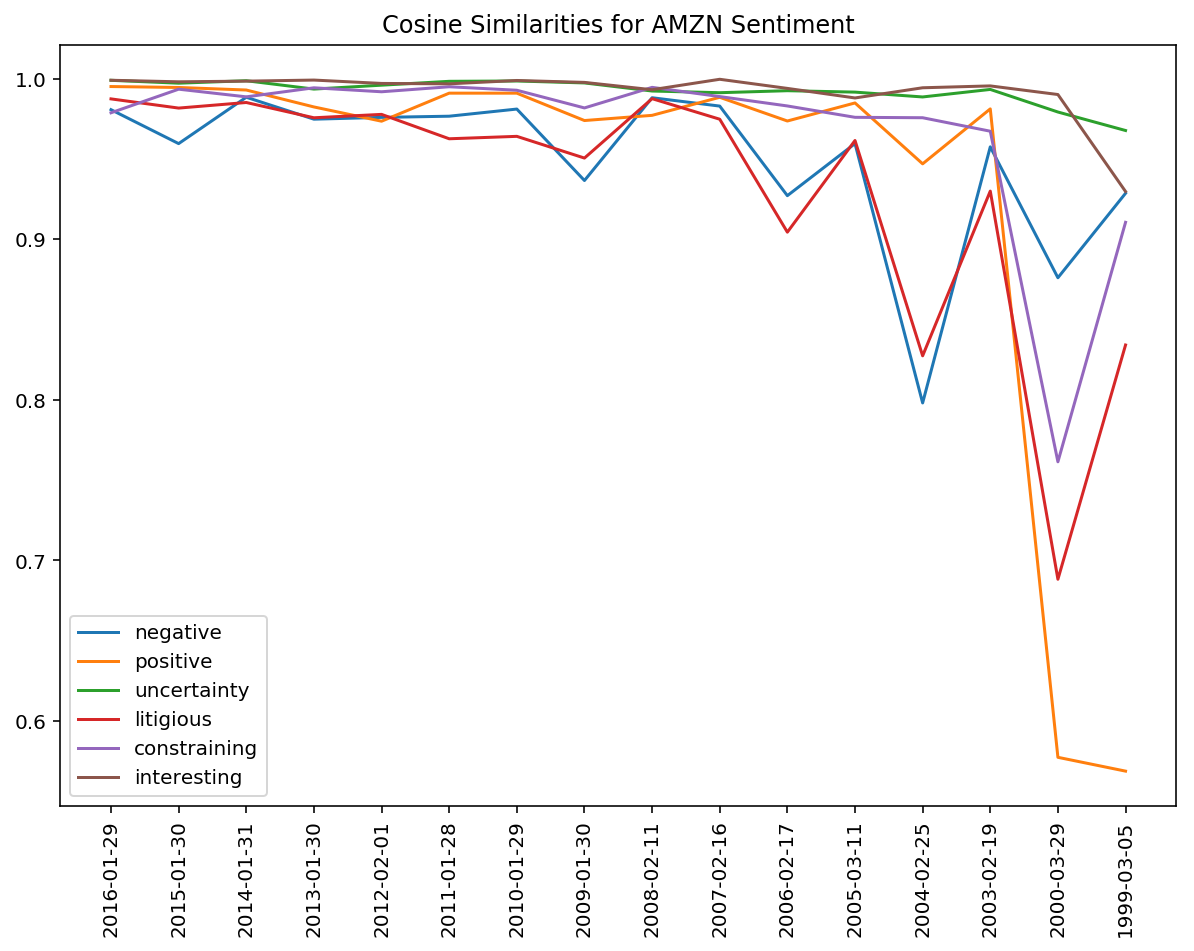

In [28]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


plot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
    sentiments)